In [4]:
# Cell 1 (Additional imports)
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Bidirectional
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


C:\Users\annek\AppData\Local\Temp\ipykernel_11860\4172943127.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


Modified timestamps for file u00035s00001_hw00002.svc:
0     0
1     8
2    15
3    23
4    31
Name: timestamp, dtype: int32




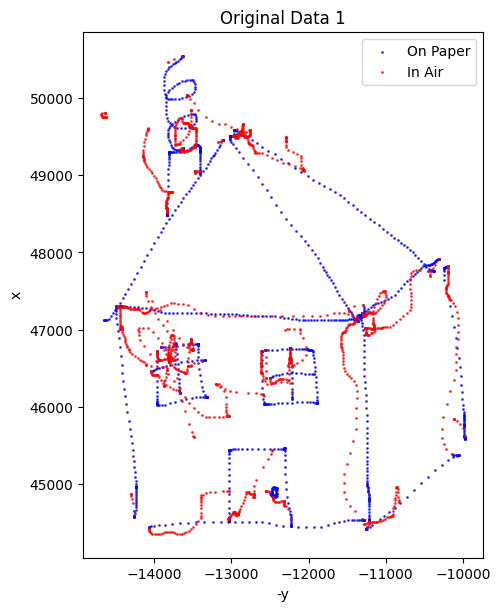

Processed data shape: (2572, 4)
Average number of data points: 2572


In [5]:
# Cell 2 (modified)
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    if num_files_to_use:
        svc_files = random.sample(svc_files, num_files_to_use)

    data_frames = []
    scalers = []

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        df = df.iloc[:, [0, 1, 2, 3]]  # Select x, y, timestamp, and pen_status
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for file {filename}:")
        print(df['timestamp'].head())
        print("\n")

    plt.show()

    combined_data = np.vstack([np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                               for df, scaler in zip(data_frames, scalers)])
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, combined_data, scalers, avg_data_points

directory = 'Task2'  # Directory where the .svc files are stored
data_frames, combined_data, scalers, avg_data_points = upload_and_process_files(directory, num_files_to_use=1)
print(f"Processed data shape: {combined_data.shape}")
print(f"Average number of data points: {avg_data_points}")


In [6]:
# Cell 3 (Modified VAE class and new LSTM Discriminator class)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.beta = beta
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

class LSTMDiscriminator(tf.keras.Model):
    def __init__(self, input_shape):
        super(LSTMDiscriminator, self).__init__()
        self.lstm = tf.keras.Sequential([
            Input(shape=input_shape),
            Bidirectional(LSTM(64, return_sequences=True)),
            Bidirectional(LSTM(32)),
            Dense(1, activation='sigmoid')
        ])

    def call(self, inputs):
        return self.lstm(inputs)

# Function to compute VAE loss
def compute_vae_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
Epoch 1/30: 100%|██████████| 6/6 [00:06<00:00,  1.15s/batch, Total Loss=0.78, Reconstruction Loss=0.78, KL Loss=0.000623]  


Epoch 1: Total Loss = 0.780340, Reconstruction Loss = 0.780340, KL Divergence Loss = 0.000422
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.225722, MSE = 0.073183, NRMSE = 0.270523


Epoch 2/30: 100%|██████████| 6/6 [00:00<00:00, 58.46batch/s, Total Loss=0.822, Reconstruction Loss=0.822, KL Loss=0.000857]


Epoch 2: Total Loss = 0.778028, Reconstruction Loss = 0.778028, KL Divergence Loss = 0.000788
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.223504, MSE = 0.073520, NRMSE = 0.271146


Epoch 3/30: 100%|██████████| 6/6 [00:00<00:00, 45.33batch/s, Total Loss=0.776, Reconstruction Loss=0.776, KL Loss=0.00233]


Epoch 3: Total Loss = 0.764620, Reconstruction Loss = 0.764620, KL Divergence Loss = 0.001769
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.222924, MSE = 0.072626, NRMSE = 0.269491


Epoch 4/30: 100%|██████████| 6/6 [00:00<00:00, 69.27batch/s, Total Loss=0.727, Reconstruction Loss=0.727, KL Loss=0.00746]


Epoch 4: Total Loss = 0.744999, Reconstruction Loss = 0.744999, KL Divergence Loss = 0.004452
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.226346, MSE = 0.073734, NRMSE = 0.271539


Epoch 5/30: 100%|██████████| 6/6 [00:00<00:00, 63.90batch/s, Total Loss=0.638, Reconstruction Loss=0.638, KL Loss=0.0173] 


Epoch 5: Total Loss = 0.690565, Reconstruction Loss = 0.690565, KL Divergence Loss = 0.010671
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.226658, MSE = 0.073560, NRMSE = 0.271220


Epoch 6/30: 100%|██████████| 6/6 [00:00<00:00, 67.30batch/s, Total Loss=0.548, Reconstruction Loss=0.548, KL Loss=0.0415]


Epoch 6: Total Loss = 0.559968, Reconstruction Loss = 0.559968, KL Divergence Loss = 0.026189
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.223625, MSE = 0.072275, NRMSE = 0.268840


Epoch 7/30: 100%|██████████| 6/6 [00:00<00:00, 62.27batch/s, Total Loss=0.147, Reconstruction Loss=0.147, KL Loss=0.1]   


Epoch 7: Total Loss = 0.265937, Reconstruction Loss = 0.265937, KL Divergence Loss = 0.064745
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.222916, MSE = 0.073366, NRMSE = 0.270862


Epoch 8/30: 100%|██████████| 6/6 [00:00<00:00, 69.03batch/s, Total Loss=0.0991, Reconstruction Loss=0.0991, KL Loss=0.174]


Epoch 8: Total Loss = 0.105217, Reconstruction Loss = 0.105217, KL Divergence Loss = 0.140646
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.225216, MSE = 0.072548, NRMSE = 0.269348


Epoch 9/30: 100%|██████████| 6/6 [00:00<00:00, 68.80batch/s, Total Loss=0.0737, Reconstruction Loss=0.0737, KL Loss=0.235]


Epoch 9: Total Loss = 0.078687, Reconstruction Loss = 0.078687, KL Divergence Loss = 0.237304
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.230327, MSE = 0.074539, NRMSE = 0.273018


Epoch 10/30: 100%|██████████| 6/6 [00:00<00:00, 60.20batch/s, Total Loss=0.0684, Reconstruction Loss=0.0684, KL Loss=0.387]


Epoch 10: Total Loss = 0.077609, Reconstruction Loss = 0.077609, KL Divergence Loss = 0.337829
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.228023, MSE = 0.073611, NRMSE = 0.271314


Epoch 11/30: 100%|██████████| 6/6 [00:00<00:00, 69.15batch/s, Total Loss=0.0708, Reconstruction Loss=0.0708, KL Loss=0.42] 


Epoch 11: Total Loss = 0.078471, Reconstruction Loss = 0.078470, KL Divergence Loss = 0.396103
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.230781, MSE = 0.074475, NRMSE = 0.272901


Epoch 12/30: 100%|██████████| 6/6 [00:00<00:00, 69.00batch/s, Total Loss=0.0707, Reconstruction Loss=0.0707, KL Loss=0.472]


Epoch 12: Total Loss = 0.076459, Reconstruction Loss = 0.076459, KL Divergence Loss = 0.433680
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.230628, MSE = 0.074328, NRMSE = 0.272632


Epoch 13/30: 100%|██████████| 6/6 [00:00<00:00, 58.71batch/s, Total Loss=0.0575, Reconstruction Loss=0.0575, KL Loss=0.423]


Epoch 13: Total Loss = 0.073318, Reconstruction Loss = 0.073318, KL Divergence Loss = 0.441846
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.232313, MSE = 0.075275, NRMSE = 0.274363


Epoch 14/30: 100%|██████████| 6/6 [00:00<00:00, 76.64batch/s, Total Loss=0.0723, Reconstruction Loss=0.0723, KL Loss=0.419]


Epoch 14: Total Loss = 0.076408, Reconstruction Loss = 0.076408, KL Divergence Loss = 0.448239
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.233497, MSE = 0.075734, NRMSE = 0.275198


Epoch 15/30: 100%|██████████| 6/6 [00:00<00:00, 62.82batch/s, Total Loss=0.0699, Reconstruction Loss=0.0699, KL Loss=0.4]  


Epoch 15: Total Loss = 0.074226, Reconstruction Loss = 0.074226, KL Divergence Loss = 0.444932
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.233377, MSE = 0.075796, NRMSE = 0.275311


Epoch 16/30: 100%|██████████| 6/6 [00:00<00:00, 58.82batch/s, Total Loss=0.0654, Reconstruction Loss=0.0654, KL Loss=0.464]


Epoch 16: Total Loss = 0.072877, Reconstruction Loss = 0.072876, KL Divergence Loss = 0.454094
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.234068, MSE = 0.075966, NRMSE = 0.275619


Epoch 17/30: 100%|██████████| 6/6 [00:00<00:00, 69.41batch/s, Total Loss=0.0685, Reconstruction Loss=0.0685, KL Loss=0.398]


Epoch 17: Total Loss = 0.073857, Reconstruction Loss = 0.073857, KL Divergence Loss = 0.442886
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.234687, MSE = 0.076364, NRMSE = 0.276341


Epoch 18/30: 100%|██████████| 6/6 [00:00<00:00, 58.88batch/s, Total Loss=0.0709, Reconstruction Loss=0.0709, KL Loss=0.402]


Epoch 18: Total Loss = 0.073286, Reconstruction Loss = 0.073286, KL Divergence Loss = 0.441221
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.236619, MSE = 0.077145, NRMSE = 0.277749


Epoch 19/30: 100%|██████████| 6/6 [00:00<00:00, 69.47batch/s, Total Loss=0.0807, Reconstruction Loss=0.0807, KL Loss=0.349]


Epoch 19: Total Loss = 0.075439, Reconstruction Loss = 0.075438, KL Divergence Loss = 0.430272
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.236543, MSE = 0.077683, NRMSE = 0.278717


Epoch 20/30: 100%|██████████| 6/6 [00:00<00:00, 66.05batch/s, Total Loss=0.0848, Reconstruction Loss=0.0848, KL Loss=0.45] 


Epoch 20: Total Loss = 0.075312, Reconstruction Loss = 0.075312, KL Divergence Loss = 0.444111
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.235632, MSE = 0.077209, NRMSE = 0.277865


Epoch 21/30: 100%|██████████| 6/6 [00:00<00:00, 64.06batch/s, Total Loss=0.0766, Reconstruction Loss=0.0766, KL Loss=0.408]


Epoch 21: Total Loss = 0.073397, Reconstruction Loss = 0.073396, KL Divergence Loss = 0.435082
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.236946, MSE = 0.077574, NRMSE = 0.278521


Epoch 22/30: 100%|██████████| 6/6 [00:00<00:00, 71.61batch/s, Total Loss=0.0782, Reconstruction Loss=0.0782, KL Loss=0.456]


Epoch 22: Total Loss = 0.072904, Reconstruction Loss = 0.072903, KL Divergence Loss = 0.439470
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.234718, MSE = 0.076963, NRMSE = 0.277421


Epoch 23/30: 100%|██████████| 6/6 [00:00<00:00, 73.95batch/s, Total Loss=0.0787, Reconstruction Loss=0.0787, KL Loss=0.363]


Epoch 23: Total Loss = 0.074032, Reconstruction Loss = 0.074032, KL Divergence Loss = 0.423748
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.237586, MSE = 0.077985, NRMSE = 0.279258


Epoch 24/30: 100%|██████████| 6/6 [00:00<00:00, 61.93batch/s, Total Loss=0.0728, Reconstruction Loss=0.0728, KL Loss=0.507]


Epoch 24: Total Loss = 0.073056, Reconstruction Loss = 0.073055, KL Divergence Loss = 0.441033
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.239048, MSE = 0.078554, NRMSE = 0.280276


Epoch 25/30: 100%|██████████| 6/6 [00:00<00:00, 68.37batch/s, Total Loss=0.0578, Reconstruction Loss=0.0578, KL Loss=0.441]


Epoch 25: Total Loss = 0.069284, Reconstruction Loss = 0.069283, KL Divergence Loss = 0.424906
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.234771, MSE = 0.077187, NRMSE = 0.277825


Epoch 26/30: 100%|██████████| 6/6 [00:00<00:00, 72.04batch/s, Total Loss=0.067, Reconstruction Loss=0.067, KL Loss=0.432]  


Epoch 26: Total Loss = 0.068896, Reconstruction Loss = 0.068896, KL Divergence Loss = 0.415908
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.242503, MSE = 0.081390, NRMSE = 0.285289


Epoch 27/30: 100%|██████████| 6/6 [00:00<00:00, 71.78batch/s, Total Loss=0.0815, Reconstruction Loss=0.0815, KL Loss=0.424]


Epoch 27: Total Loss = 0.067564, Reconstruction Loss = 0.067564, KL Divergence Loss = 0.406313
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.240762, MSE = 0.080613, NRMSE = 0.283925


Epoch 28/30: 100%|██████████| 6/6 [00:00<00:00, 40.03batch/s, Total Loss=0.0647, Reconstruction Loss=0.0647, KL Loss=0.331]


Epoch 28: Total Loss = 0.062194, Reconstruction Loss = 0.062193, KL Divergence Loss = 0.391024
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.242675, MSE = 0.081365, NRMSE = 0.285246


Epoch 29/30: 100%|██████████| 6/6 [00:00<00:00, 60.26batch/s, Total Loss=0.0643, Reconstruction Loss=0.0643, KL Loss=0.399]


Epoch 29: Total Loss = 0.059381, Reconstruction Loss = 0.059380, KL Divergence Loss = 0.409165
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.244952, MSE = 0.083027, NRMSE = 0.288144


Epoch 30/30: 100%|██████████| 6/6 [00:00<00:00, 72.12batch/s, Total Loss=0.048, Reconstruction Loss=0.048, KL Loss=0.485]  


Epoch 30: Total Loss = 0.052037, Reconstruction Loss = 0.052037, KL Divergence Loss = 0.447170
Discriminator Loss = 0.000000, Generator Loss = 0.000000
MAE = 0.242720, MSE = 0.081673, NRMSE = 0.285785
Final MAE: 0.242720
Final MSE: 0.081673
Final NRMSE: 0.285785
Training completed.


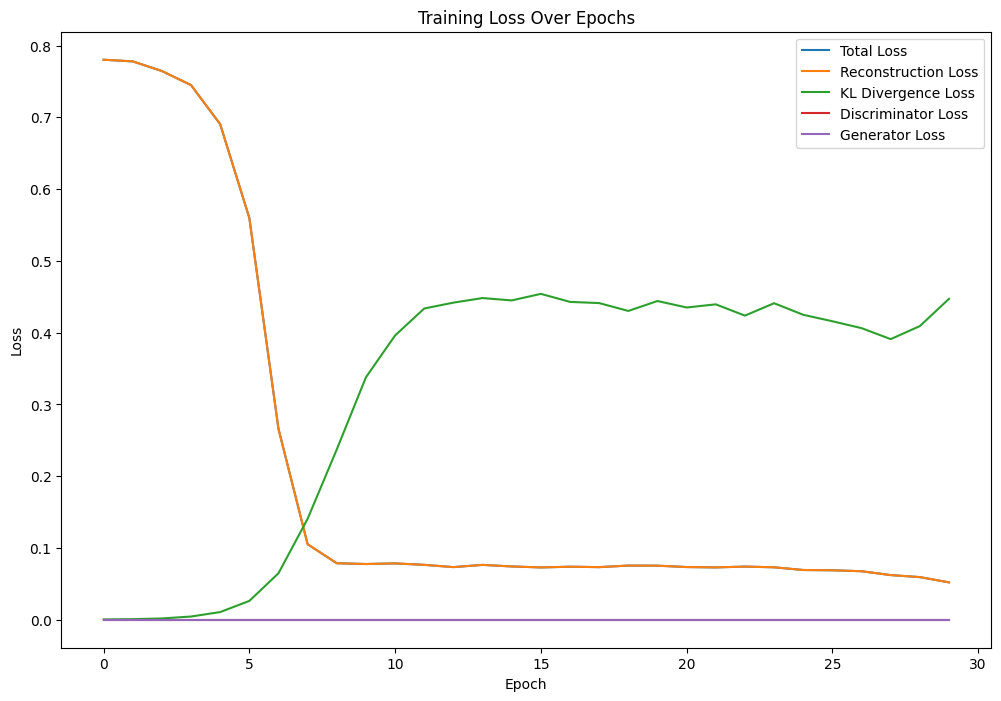

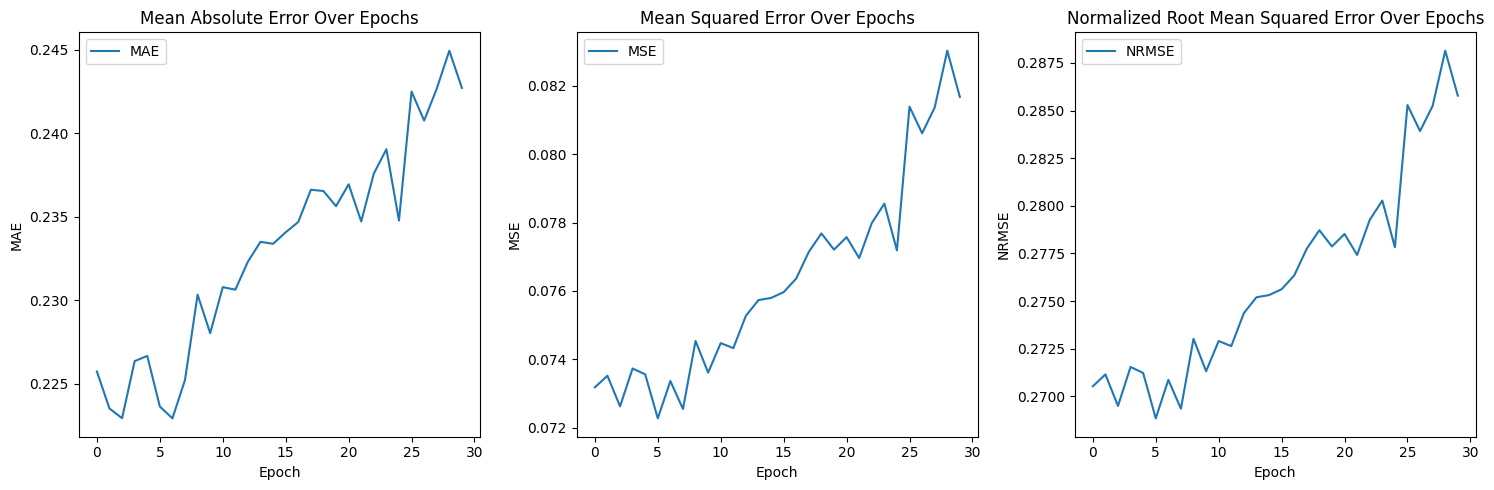

In [7]:
# Cell 4 (Modified training loop)
@tf.function
def train_vae_step(vae, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_vae_loss(vae, x)
        total_loss = reconstruction_loss + total_kl_loss
    gradients = tape.gradient(total_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss

@tf.function
def train_discriminator_step(discriminator, real_data, fake_data, optimizer):
    with tf.GradientTape() as tape:
        real_output = discriminator(real_data)
        fake_output = discriminator(fake_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
        fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
    gradients = tape.gradient(total_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return total_loss

@tf.function
def train_generator_step(vae, discriminator, x, optimizer):
    with tf.GradientTape() as tape:
        x_reconstructed, _, _ = vae(x)
        fake_output = discriminator(x_reconstructed)
        generator_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    gradients = tape.gradient(generator_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return generator_loss

# Main training loop
latent_dim = 128
beta = 0.000001
learning_rate = 0.001

vae = VAE(latent_dim, beta)
discriminator = LSTMDiscriminator((None, 4))
vae_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices(combined_data).shuffle(10000).batch(batch_size)

epochs = 30
vae_only_epochs = 31
gan_interval = 10
early_stopping_patience = 100
min_delta = 0.0001
best_loss = float('inf')
patience_counter = 0

total_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
discriminator_loss_history = []
generator_loss_history = []
mae_history = []
mse_history = []
nrmse_history = []

for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    discriminator_loss_sum = 0
    generator_loss_sum = 0
    num_batches = len(train_dataset)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            # Train VAE
            total_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, vae_optimizer)
            total_loss += total_loss_batch
            reconstruction_loss_sum += reconstruction_loss
            kl_loss_sum += kl_loss

            # Train GAN (after vae_only_epochs and every gan_interval epochs)
            if epoch >= vae_only_epochs and (epoch - vae_only_epochs) % gan_interval == 0:
                fake_data, _, _ = vae(batch)
                discriminator_loss = train_discriminator_step(discriminator, batch, fake_data, discriminator_optimizer)
                generator_loss = train_generator_step(vae, discriminator, batch, vae_optimizer)
                discriminator_loss_sum += discriminator_loss
                generator_loss_sum += generator_loss

            pbar.update(1)
            pbar.set_postfix({'Total Loss': float(total_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    avg_total_loss = total_loss / num_batches
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches
    avg_discriminator_loss = discriminator_loss_sum / num_batches if epoch >= vae_only_epochs else 0
    avg_generator_loss = generator_loss_sum / num_batches if epoch >= vae_only_epochs else 0

    total_loss_history.append(avg_total_loss)
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)
    discriminator_loss_history.append(avg_discriminator_loss)
    generator_loss_history.append(avg_generator_loss)

    # Calculate MAE, MSE, NRMSE
    augmented_data = vae.decode(tf.random.normal(shape=(combined_data.shape[0], latent_dim))).numpy()
    mae = mean_absolute_error(combined_data[:, :2], augmented_data[:, :2])
    mse = mean_squared_error(combined_data[:, :2], augmented_data[:, :2])
    rmse = np.sqrt(mse)
    nrmse = rmse / (combined_data[:, :2].max() - combined_data[:, :2].min())

    mae_history.append(mae)
    mse_history.append(mse)
    nrmse_history.append(nrmse)

    print(f"Epoch {epoch+1}: Total Loss = {avg_total_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"Discriminator Loss = {avg_discriminator_loss:.6f}, Generator Loss = {avg_generator_loss:.6f}")
    print(f"MAE = {mae:.6f}, MSE = {mse:.6f}, NRMSE = {nrmse:.6f}")

    if avg_total_loss < best_loss - min_delta:
        best_loss = avg_total_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Final output of metrics
print(f"Final MAE: {mae_history[-1]:.6f}")
print(f"Final MSE: {mse_history[-1]:.6f}")
print(f"Final NRMSE: {nrmse_history[-1]:.6f}")

print("Training completed.")
plt.ioff()  # Turn off interactive mode
plt.show()

# Plot loss history
plt.figure(figsize=(12, 8))
plt.plot(total_loss_history, label='Total Loss')
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.plot(discriminator_loss_history, label='Discriminator Loss')
plt.plot(generator_loss_history, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot MAE, MSE, and NRMSE history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(mae_history, label='MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(mse_history, label='MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Mean Squared Error Over Epochs')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()



<VAE name=vae, built=True>


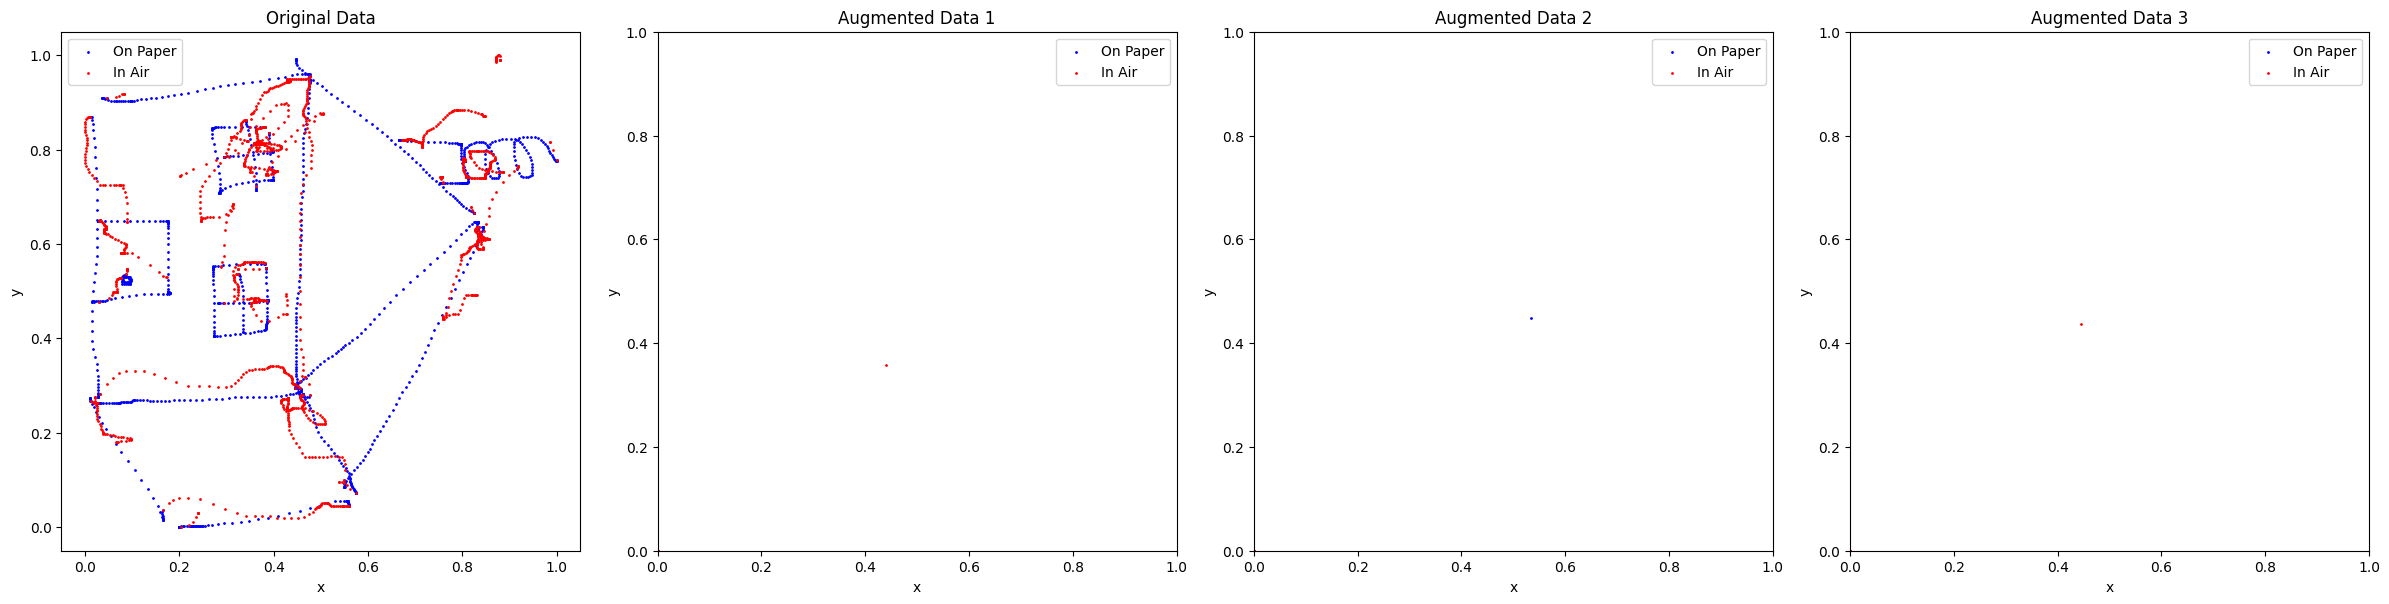

In [8]:
# Cell 6 (Modified for VAE-GAN)
def generate_augmented_data(vae, discriminator, num_augmented_files, avg_data_points, latent_dim, variability=0.1):
    augmented_datasets = []
    
    for _ in range(num_augmented_files):
        # Generate latent vector
        z = tf.random.normal(shape=(1, latent_dim))
        
        # Generate fake data using the VAE decoder
        augmented_data = vae.decode(z).numpy()

        # Determine the number of data points for this augmented dataset
        num_points = int(avg_data_points * (1 + variability * (random.random() - 0.5) * 2))
        
        # Truncate or pad the augmented data to match the number of points
        if num_points < augmented_data.shape[0]:
            augmented_data = augmented_data[:num_points]
        else:
            padding = np.zeros((num_points - augmented_data.shape[0], augmented_data.shape[1]))
            augmented_data = np.vstack([augmented_data, padding])

        # Post-process pen status
        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        
        # Ensure timestamps are in sequence
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

num_augmented_files = 3
latent_dim = 128  # Same as in VAE-GAN
print(vae)  # Check if the vae object is defined
augmented_datasets = generate_augmented_data(vae, discriminator, num_augmented_files, avg_data_points, latent_dim)

# Visualize the original and augmented data side by side
fig, axs = plt.subplots(1, num_augmented_files + 1, figsize=(6*(num_augmented_files + 1), 6))
original_on_paper = combined_data[combined_data[:, 3] == 1]
original_in_air = combined_data[combined_data[:, 3] == 0]
axs[0].scatter(original_on_paper[:, 0], original_on_paper[:, 1], c='b', s=1, label='On Paper')
axs[0].scatter(original_in_air[:, 0], original_in_air[:, 1], c='r', s=1, label='In Air')
axs[0].set_title('Original Data')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')
axs[0].legend()

# Set consistent axis limits for square aspect ratio
x_min, x_max = combined_data[:, 0].min(), combined_data[:, 0].max()
y_min, y_max = combined_data[:, 1].min(), combined_data[:, 1].max()

for i, augmented_data in enumerate(augmented_datasets):
    augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
    augmented_in_air = augmented_data[augmented_data[:, 3] == 0]
    axs[i+1].scatter(augmented_on_paper[:, 0], augmented_on_paper[:, 1], c='b', s=1, label='On Paper')
    axs[i+1].scatter(augmented_in_air[:, 0], augmented_in_air[:, 1], c='r', s=1, label='In Air')
    axs[i+1].set_title(f'Augmented Data {i+1}')
    axs[i+1].set_xlabel('x')
    axs[i+1].set_ylabel('y')
    axs[i+1].set_aspect('equal')
    axs[i+1].set_xlim(x_min, x_max)
    axs[i+1].set_ylim(y_min, y_max)
    axs[i+1].legend()

plt.tight_layout()
plt.show()
